In [58]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, normaltest

from datasets import Dataset
import losses
import cnns
from models import Model
from cropping import align, crop_face, detect_landmarks, crop_feature, draw_boxes

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tqdm import tqdm
import concurrent.futures
import sys
import saliency.core as saliency
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib

In [2]:
names = np.array([
    "nose",
    "lips",
    "eyes",
    "left_eye",
    "right_eye",
    "cheeks",
    "right_cheek",
    "left_cheek",
    "chin",
    "eyebrows",
    "left_eyebrow",
    "right_eyebrow",
])

names2 = np.array([
    "nose",
    "lips",
    "eyes",
    "left eye",
    "right eye",
    "cheeks",
    "right cheek",
    "left cheek",
    "chin",
    "eyebrows",
    "left eyebrow",
    "right eyebrow",
])


os.chdir("C:/Users/ugail/Documents/paperV2")

In [3]:
def transform_coordinates(p1, p2, m1, m2):
    sf = 224/(m2-m1)
    m = np.max(m2-m1)
    p1 = np.clip(p1-m1, a_min=0, a_max=m)
    p2 = np.clip(p2-m1, a_min=0, a_max=m)
    p1 = np.clip(np.uint8(p1*sf), a_min=0, a_max=224)
    p2 = np.clip(np.uint8(p2*sf), a_min=0, a_max=224)

    return p1, p2

In [4]:
def xrai(dataset, output_size, mode):
    with open(f"{dataset}/{mode}.txt", "r") as f:
        lines = f.readlines()
        y_train = np.array([l.split(" ")[6:7] for l in lines], np.float32)
        files = [l.split(" ")[0] for l in lines]

    cnn = cnns.ResNet50(weights="vggface")
    cnn.construct()
    resnet = Model(
        cnn, 
        parent_name=dataset,
        name="mediapipe", 
        loss="categorical_crossentropy", 
        output_size=output_size,
        load_weights=True
    )
    resnet.construct(activation="softmax")

    def call_model_function(images, call_model_args=None, expected_keys=None):
        with tf.GradientTape() as tape:
            x = tf.convert_to_tensor(images)
            tape.watch(x)
            result = resnet.full_model(x)
            grads = tape.gradient(result, x)
        return {saliency.INPUT_OUTPUT_GRADIENTS: grads}

    xrai_object = saliency.XRAI()
    n = len(files)
    A = np.zeros((n,224,224))
    for i in range(n):
        image = align(os.path.join(dataset,"images",files[i]))
        m1, m2 = crop_face(image)
        image_resized = cv2.resize(
            image[m1[1]:m2[1],m1[0]:m2[0]], 
            (224,224), 
            interpolation=cv2.INTER_LANCZOS4
        )[...,::-1]

        xrai_attributions = xrai_object.GetMask(
            resnet.preprocess(image_resized), 
            call_model_function, 
            None, 
            batch_size=20
        )

        A[i] = xrai_attributions

    np.save(f"{dataset}/xrai_{mode}.npy", A)
    return A

In [8]:
def get_attributions(dataset, mode):
    with open(f"{dataset}/{mode}.txt", "r") as f:
        lines = f.readlines()
        y_train = np.array([l.split(" ")[6:7] for l in lines], np.float32)
        files = [l.split(" ")[0] for l in lines]

    A = np.load(f"{dataset}/xrai_{mode}.npy")
    scores = np.zeros((len(A),len(names)))
    for i in range(len(A)):
        try:
            image = align(os.path.join(dataset,"images",files[i]))
            m1, m2 = crop_face(image)
            _, detection_result = detect_landmarks(image=image)
            
            for j in range(len(names)):
                #normalised = (A[i] - np.min(A[i])) / (np.max(A[i]) - np.min(A[i]))
                normalised = A[i]
                s1 = np.sum(normalised)
                n1 = len(normalised.flatten())

                if names[j] == "cheeks":
                    _, p1, p2 = crop_feature("left_cheek", image, detection_result)
                    _, q1, q2 = crop_feature("right_cheek", image, detection_result)
                    p1, p2 = transform_coordinates(p1, p2, m1, m2)
                    q1, q2 = transform_coordinates(q1, q2, m1, m2)

                    s2 = np.sum(normalised[p1[1]:p2[1],p1[0]:p2[0]])
                    s3 = np.sum(normalised[q1[1]:q2[1],q1[0]:q2[0]])
                    n2 = len(normalised[p1[1]:p2[1],p1[0]:p2[0]].flatten())
                    n3 = len(normalised[q1[1]:q2[1],q1[0]:q2[0]].flatten())
                    u1 = (s1-(s2+s3))/(n1-(n2+n3))
                    u2 = (s2+s3)/(n2+n3)

                else:
                    _, p1, p2 = crop_feature(names[j], image, detection_result)
                    p1, p2 = transform_coordinates(p1, p2, m1, m2)
                    s2 = np.sum(normalised[p1[1]:p2[1],p1[0]:p2[0]])
                    n2 = len(normalised[p1[1]:p2[1],p1[0]:p2[0]].flatten())
                    u1 = (s1-s2)/(n1-n2)
                    u2 = s2/n2

                scores[i][j] = (u2-u1)/u1
        except:
            print(i)

    for i in range(len(scores)):
        if np.isnan(np.min(scores[i])):
            scores[i] = scores[i-1]
    
    return scores, np.mean(scores, axis=0), np.std(scores, axis=0)

In [67]:
def create_graph(scores, mu, sigma, name):
    p = mu.argsort()
    idx = [i for i in p if i not in [3,4,6,7,10,11]]

    for i in p:
        print(rf"{names2[i]} & {np.round(mu[i],4)} & {np.round(sigma[i],4)} \\")

    plt.boxplot(scores[...,idx], labels=names2[idx], vert=False, showfliers=False)
    plt.xlabel("Region Attribution")
    plt.tight_layout()
    plt.savefig(name, dpi=300)
    plt.show()
    
    print()
    for i in p:
        print(rf"{names2[i]} & {normaltest(scores[...,i]).pvalue} \\")

In [37]:
scores1, mu1, sigma1 = get_attributions("MEBeauty", "test")

C:\Users\ugail\AppData\Local\Temp\ipykernel_21084\2229277115.py:40: RuntimeWarning: invalid value encountered in double_scalars
  u2 = s2/n2


chin & -0.4091 & 0.1559 \\
left cheek & -0.1507 & 0.1989 \\
cheeks & -0.1304 & 0.1326 \\
right cheek & -0.0633 & 0.2051 \\
left eyebrow & 0.2054 & 0.285 \\
lips & 0.233 & 0.3345 \\
right eyebrow & 0.2495 & 0.2716 \\
eyebrows & 0.2536 & 0.249 \\
left eye & 0.3156 & 0.2536 \\
eyes & 0.399 & 0.2354 \\
right eye & 0.4116 & 0.2758 \\
nose & 1.0801 & 0.5367 \\


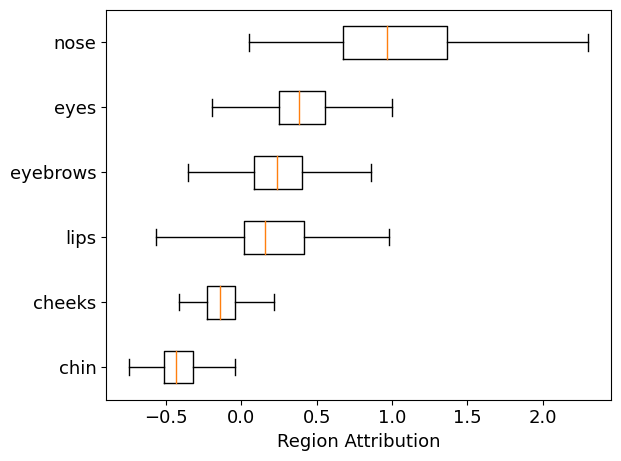


chin & 9.775162323874139e-14 \\
left cheek & 1.2113398676919048e-12 \\
cheeks & 0.05900044351912465 \\
right cheek & 3.3630853567319807e-05 \\
left eyebrow & 0.007399072680278099 \\
lips & 7.849233431498827e-14 \\
right eyebrow & 9.27053541161904e-09 \\
eyebrows & 2.641067460535323e-09 \\
left eye & 0.08197383256718448 \\
eyes & 0.0001733465422081461 \\
right eye & 1.591502872618527e-08 \\
nose & 2.572809694901736e-20 \\


In [68]:
matplotlib.rcParams.update({'font.size': 13})
create_graph(scores1, mu1, sigma1, "xrai_mebeauty_test.png")

In [50]:
scores2, mu2, sigma2 = get_attributions("MEBeauty", "train")

TypeError: get_attributions() takes 2 positional arguments but 3 were given

chin & -0.3615 & 0.1667 \\
cheeks & -0.1235 & 0.1348 \\
left cheek & -0.1132 & 0.1835 \\
right cheek & -0.0979 & 0.1961 \\
right eyebrow & 0.2302 & 0.2564 \\
left eyebrow & 0.2615 & 0.2799 \\
eyebrows & 0.2735 & 0.2324 \\
lips & 0.3281 & 0.3649 \\
left eye & 0.3399 & 0.2597 \\
right eye & 0.3517 & 0.2588 \\
eyes & 0.3788 & 0.2324 \\
nose & 0.8867 & 0.3889 \\


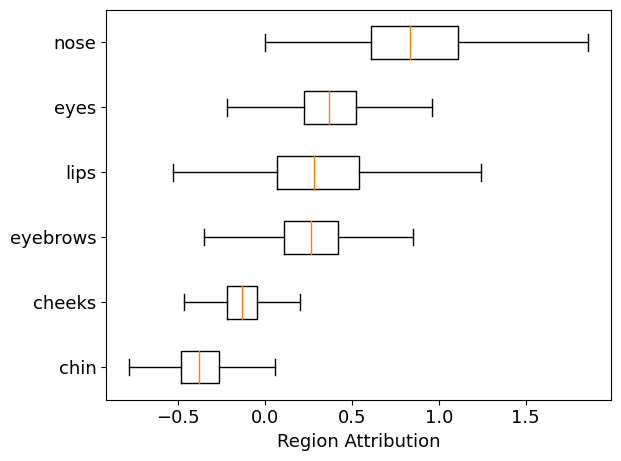


chin & 1.5154439662148484e-27 \\
cheeks & 2.7666834668240396e-35 \\
left cheek & 5.105723683113818e-52 \\
right cheek & 3.9786775058047495e-29 \\
right eyebrow & 1.0063242089758677e-07 \\
left eyebrow & 2.2450621225826325e-05 \\
eyebrows & 0.0030680112409336006 \\
lips & 3.454844727406546e-33 \\
left eye & 2.8656506519937425e-18 \\
right eye & 6.615178271072628e-18 \\
eyes & 9.692615044112987e-10 \\
nose & 1.5980178224424324e-34 \\


In [69]:
create_graph(scores2, mu2, sigma2, "xrai_mebeauty_train.png")

In [43]:
scores3, mu3, sigma3 = get_attributions("SCUT-FBP5500", "test")

chin & -0.2782 & 0.1806 \\
right cheek & -0.1496 & 0.1572 \\
right eyebrow & -0.1092 & 0.1793 \\
eyebrows & -0.0563 & 0.1592 \\
cheeks & -0.0226 & 0.1309 \\
left eyebrow & 0.0043 & 0.1895 \\
left cheek & 0.1173 & 0.1957 \\
right eye & 0.3653 & 0.2228 \\
eyes & 0.5168 & 0.2119 \\
lips & 0.5266 & 0.3663 \\
left eye & 0.577 & 0.2466 \\
nose & 0.9271 & 0.2797 \\


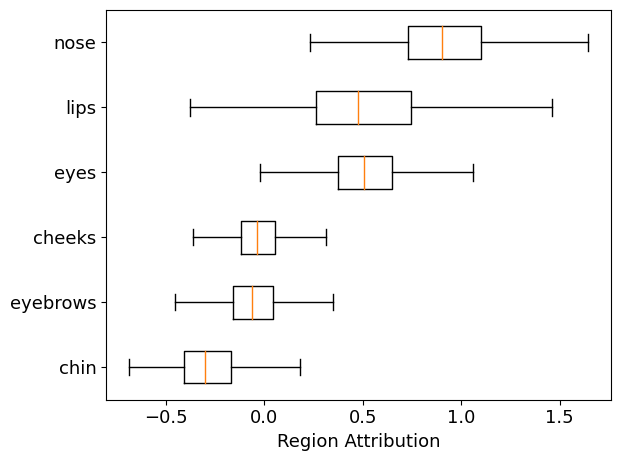


chin & 5.0098417307538576e-29 \\
right cheek & 7.352367382062885e-28 \\
right eyebrow & 2.5955856844769e-12 \\
eyebrows & 0.0006006439591809395 \\
cheeks & 1.3050600308231962e-18 \\
left eyebrow & 1.0796778460296313e-12 \\
left cheek & 3.561141908886747e-21 \\
right eye & 3.2374349870771134e-29 \\
eyes & 4.4137667172656515e-14 \\
lips & 1.107388802626581e-40 \\
left eye & 4.402080869590802e-19 \\
nose & 2.71480914438892e-32 \\


In [70]:
create_graph(scores3, mu3, sigma3, "xrai_scut_test.png")

In [45]:
scores4, mu4, sigma4 = get_attributions("SCUT-FBP5500", "train")

chin & -0.3313 & 0.1724 \\
right cheek & -0.1371 & 0.1702 \\
cheeks & -0.1253 & 0.1348 \\
left cheek & -0.0711 & 0.1874 \\
right eyebrow & 0.0844 & 0.2214 \\
left eyebrow & 0.1047 & 0.2164 \\
eyebrows & 0.105 & 0.1935 \\
lips & 0.351 & 0.3128 \\
right eye & 0.4864 & 0.2777 \\
left eye & 0.537 & 0.2943 \\
eyes & 0.5653 & 0.257 \\
nose & 0.9469 & 0.3227 \\


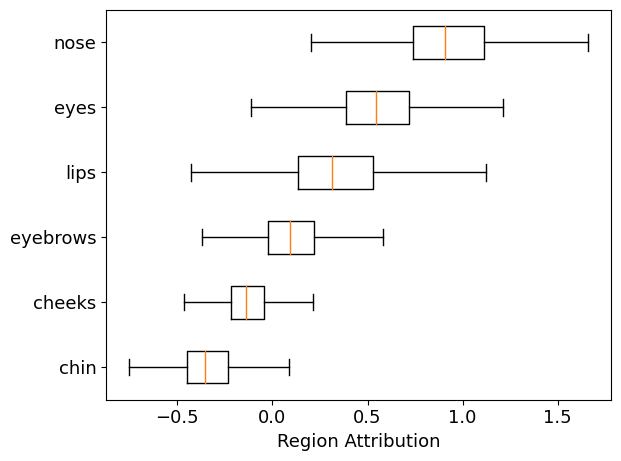


chin & 2.9320730466093896e-120 \\
right cheek & 1.324881235470779e-89 \\
cheeks & 9.23423864625641e-47 \\
left cheek & 4.888809144235847e-144 \\
right eyebrow & 4.196513182965069e-22 \\
left eyebrow & 2.027816176480008e-31 \\
eyebrows & 9.926516906311311e-33 \\
lips & 1.0385304178890286e-108 \\
right eye & 7.173118055459734e-87 \\
left eye & 1.9553319593045995e-55 \\
eyes & 1.6552278011236299e-46 \\
nose & 1.636372484883941e-222 \\


In [71]:
create_graph(scores4, mu4, sigma4, "xrai_scut_train.png")

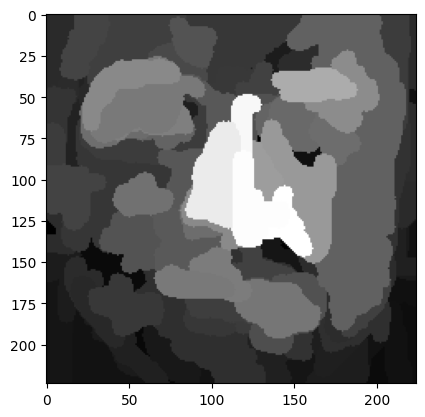

In [254]:
x = xrai_attributions-np.min(xrai_attributions)
x /= np.max(x)
plt.imshow(np.uint8(x*255), cmap="gray", vmin=0, vmax=255)

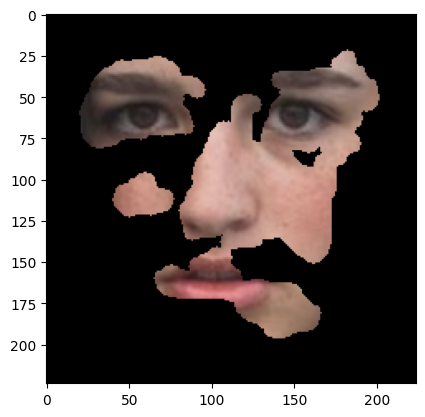

In [255]:
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
image = np.uint8(X_test[1]+mean)[...,::-1]
image[~mask] = 0
plt.imshow(image)